In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
import matplotlib.colors as mcolors
from matplotlib.patches import Ellipse


def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

# Load Data
with open('input.json', 'r') as inputFile:
    datas = json.load(inputFile)
    datas = {key:np.array(data) for key, data in datas.items()}
x1, y1 = datas['x1'], datas['y1']
x2, y2 = datas['x2'], datas['y2']
x3, y3 = datas['x3'], datas['y3']
datas = [[x1, y1], [x2, y2], [x3, y3]]

In [13]:
# import matplotlib as mpl
from sklearn.mixture import GaussianMixture as GMM

COLORS = list(mcolors.TABLEAU_COLORS.values())

class GMM_predictor(object):
    def __init__(self, x: np.ndarray, y: np.ndarray):
        self.x = x
        self.y = y
        self.classes = np.unique(self.y)
        self.num_classes = len(self.classes)
        # Set color for each class
        self.colors = dict()
        for c_idx, c in enumerate(self.classes):
            self.colors[c] = COLORS[c_idx]
        self.predictor = None # sklearn GMM object
    
    def _draw_distribution(self, ax, x:np.ndarray, y:np.ndarray, class_mapping:dict):

        for real_c in sorted(class_mapping.keys()):
            target = x[y == class_mapping[real_c], ...]
            x1 = target[:, 0]
            x2 = target[:, 1]
            ax.scatter(x1, x2, c=self.colors[real_c], s=15, label="Class {}".format(real_c))
            # Draw center
            center = np.mean(target, axis=0)
            ax.scatter(center[0], center[1], marker="D", c="orange", lw=1, edgecolors="black", s=16)
        ax.legend()

    def get_class_mapping(self):
        center = []
        for c in self.classes:
            mask = (self.y == c)
            center.append(np.mean(x[mask], axis=0))
        center = np.array(center)
        center_predict = self.predictor.means_
        distance = np.sqrt(np.sum((center[np.newaxis,...] - center_predict[:, np.newaxis, ...]) ** 2, axis= -1))
        mapping = np.argmin(distance, axis=-1)
        class_mapping = {c:i for i, c in enumerate(mapping)}

        return class_mapping
    def compute_acc(self):
        class_mapping = self.get_class_mapping()
        predict_y = self.predictor.predict(self.x)
        mapping_pred_y = np.zeros((self.y.shape))
        for real_c, c in class_mapping.items():
            mask = (predict_y == c)
            mapping_pred_y[mask] = real_c
        acc = (mapping_pred_y == self.y).sum() / len(self.y)
        return acc
    def draw_figure(self, big_title=''):
        fig = plt.figure(figsize=(12,5), tight_layout=True)
        if big_title != '':
            fig.suptitle(big_title, fontsize=14, fontweight='bold')
        # Draw origin distribution
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.set_xlabel('$x_1$')
        ax1.set_ylabel('$x_2$')
        ax1.set_title("Origin distribution")
        class_mapping = {c:c for c in self.classes}
        self._draw_distribution(ax1, self.x, self.y, class_mapping)
        
        # Draw distribution for prediction
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.set_xlabel('$x_1$')
        ax2.set_ylabel('$x_2$')
        ax2.set_title("GMM prediction distribution")
        predict_y = self.predictor.predict(self.x)
        class_mapping = self.get_class_mapping()
        self._draw_distribution(ax2, self.x, predict_y, class_mapping)
        
        # Draw Correct and Wrong
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.set_title("Correct and Wrong Points")
        ax3.set_xlabel('$x_1$')
        ax3.set_ylabel('$x_2$')
        mapping_pred_y = np.zeros((self.y.shape))
        for real_c, c in class_mapping.items():
            mask = (predict_y == c)
            mapping_pred_y[mask] = real_c
        acc = (mapping_pred_y == self.y).sum() / len(self.y)
        correct_mask = (mapping_pred_y == self.y)
        target = x[correct_mask, ...]
        ax3.scatter(target[:, 0], target[:, 1], c='g', marker='x',label="Correct Points")
        target = x[~correct_mask, ...]
        ax3.scatter(target[:, 0], target[:, 1], c='r', marker='x',label="Wrong Points")
        ax3.legend()
        x1_min = min(x[:,0])
        x2_min = min(x[:,1])
        ax3.text(x1_min, x2_min, 'Accuracy = {:.1f}%'.format(acc * 100))
       
    def set_gmm(self, **args):
        self.gmm_setting = args
        self.predictor = GMM(n_components=self.num_classes, **args)
        self.predictor.fit(self.x)


exp_setting = {'covariance_type': ['full', 'tied', 'diag', 'spherical'],
                'init_params':['kmeans', 'k-means++', 'random', 'random_from_data'],}

exp_order = ['covariance_type', 'init_params']
def gen_exp(cur_i:int, indices:list):
    cur_setting = exp_order[cur_i]
    for i in range(len(exp_setting[cur_setting])):
        if cur_i == 0:
            indices = []
        if cur_i == len(exp_setting) - 1: 
            yield indices + [i]
        else:
            yield from gen_exp(cur_i + 1, indices + [i])

results = []
for data_index, data in enumerate(datas):
    result = dict()
    x, y = data
    gmm = GMM_predictor(x, y)
    for exp in gen_exp(0, None):
        setting = dict()
        for arg, i in zip(exp_order, exp):
            setting[arg] = exp_setting[arg][i]
        gmm.set_gmm(**setting)
        acc = gmm.compute_acc()
        result[tuple(setting.values())] = acc
    results.append(result)

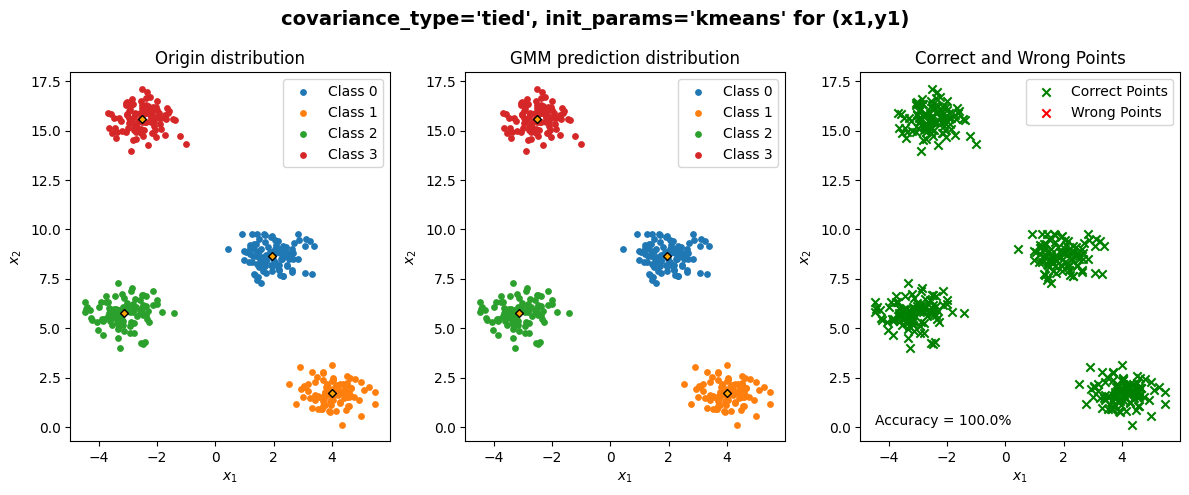

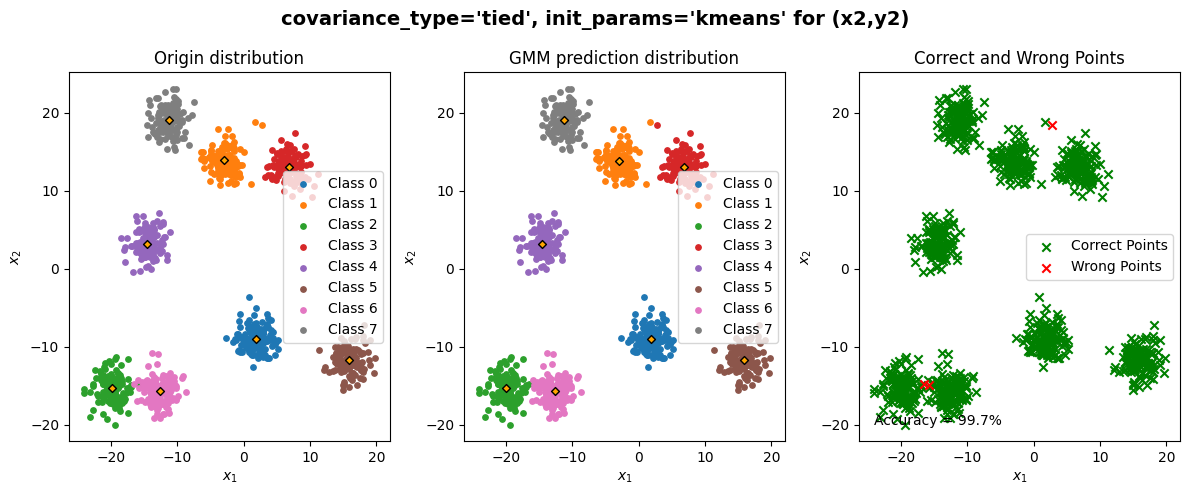

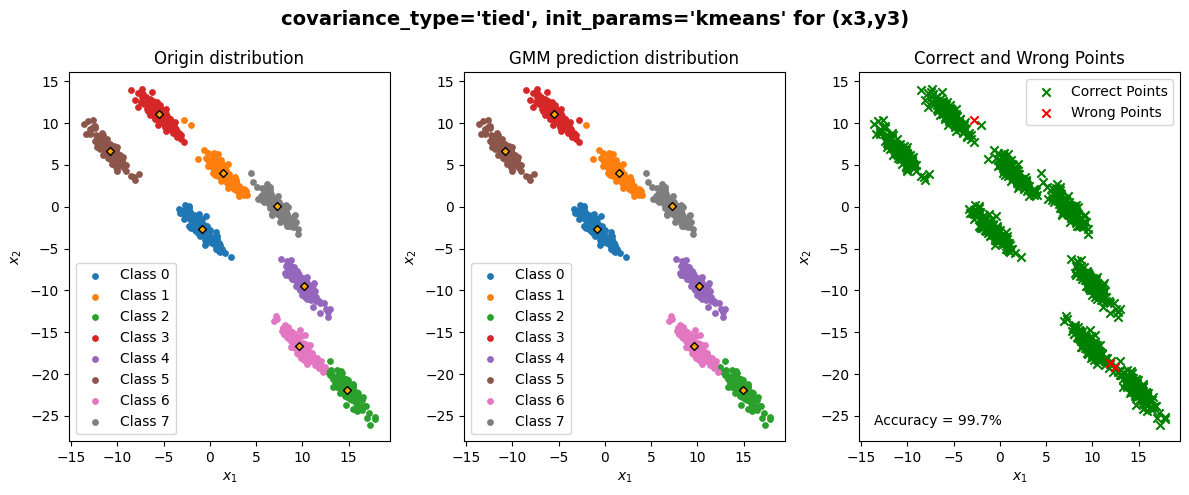

In [15]:
for data_index, data in enumerate(datas):
    x, y = data
    gmm = GMM_predictor(x, y)
    gmm.set_gmm(covariance_type='tied')
    gmm.draw_figure(big_title="covariance_type='tied', init_params='kmeans' for (x{0},y{0})".format(data_index+1))

In [17]:
import sklearn
import matplotlib
matplotlib.__version__

'3.6.2'

In [18]:
! conda list

# packages in environment at C:\Users\user\anaconda3\envs\AI_hw5:
#
# Name                    Version                   Build  Channel
asttokens                 2.0.5              pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
ca-certificates           2022.10.11           haa95532_0  
certifi                   2022.9.24        py38haa95532_0  
colorama                  0.4.5            py38haa95532_0  
contourpy                 1.0.6                    pypi_0    pypi
cycler                    0.11.0                   pypi_0    pypi
debugpy                   1.5.1            py38hd77b12b_0  
decorator                 5.1.1              pyhd3eb1b0_0  
entrypoints               0.4              py38haa95532_0  
executing                 0.8.3              pyhd3eb1b0_0  
fonttools                 4.38.0                   pypi_0    pypi
ipykernel                 6.15.2           py38haa95532_0  
ipython                   8.6.0            py38haa95532_0  
jedi   

In [10]:

for i, result in enumerate(results):
    print(i)
    lines = [','.join(exp_order) + ',accuracy(%)']

    # sorted_key = sorted(result.keys(), key=lambda k:result[k], reverse=True)
    
    for k in result.keys():
        line = ','.join(k)
        line += ',' + '{:.1f}'.format(result[k] * 100)
        lines.append(line)
        print(line)
    lines = [line + '\n' for line in lines]
    with open("exp{}_result.csv".format(i), 'w') as f:
        f.writelines(lines)
        print(k, result[k])

0
full,kmeans,100.0
full,k-means++,100.0
full,random,25.0
full,random_from_data,28.5
tied,kmeans,100.0
tied,k-means++,25.0
tied,random,25.0
tied,random_from_data,25.0
diag,kmeans,100.0
diag,k-means++,100.0
diag,random,25.0
diag,random_from_data,59.2
spherical,kmeans,100.0
spherical,k-means++,100.0
spherical,random,25.0
spherical,random_from_data,65.0
1
full,kmeans,99.6
full,k-means++,99.5
full,random,24.4
full,random_from_data,87.3
tied,kmeans,99.7
tied,k-means++,12.5
tied,random,19.1
tied,random_from_data,8.2
diag,kmeans,99.7
diag,k-means++,99.7
diag,random,12.5
diag,random_from_data,70.5
spherical,kmeans,99.7
spherical,k-means++,99.6
spherical,random,12.5
spherical,random_from_data,66.8
2
full,kmeans,99.6
full,k-means++,99.6
full,random,12.5
full,random_from_data,74.5
tied,kmeans,99.7
tied,k-means++,12.5
tied,random,12.5
tied,random_from_data,12.5
diag,kmeans,99.3
diag,k-means++,99.2
diag,random,12.5
diag,random_from_data,50.2
spherical,kmeans,99.2
spherical,k-means++,99.2
spherical,